# Cleaning and Preprocessing

### Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import wordcloud
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore") # shhhhhhhh

In [4]:
def make_cloud(X):
    '''
    Uses X value of data, which should be text columns
    '''

    wc = wordcloud.WordCloud(max_words=50, 
                             width=700, 
                             height=400, 
                             background_color='white',
                            )

    

    cloud = wc.generate(X.str.cat())

    return cloud.to_image()

# This function is included in this notebook as an easier approach
# to using functions in the workflow rather than building an entire class
# as in 05_Functions

## Import the data

In [5]:
scitech = pd.read_csv('../data/scitech.csv')

### Nulls

In [6]:
scitech.isnull().sum()

Unnamed: 0    0
title         0
subreddit     0
dtype: int64

In [7]:
scitech.head()

,Unnamed: 0,title,subreddit
0,0,"""Even quantum networks can only be expected to...",science
1,1,Cannabis and similar substances that interact ...,science
2,2,Study ties poor sleep to reduced memory perfor...,science
3,3,Single-cell analysis reveals T cell infiltrati...,science
4,4,Meta-analysis of stereotype threat indicates t...,science


In [8]:
scitech.tail()

,Unnamed: 0,title,subreddit
19883,19883,Cloudflare Global Disruption,technology
19884,19884,Google’s Jigsaw Was Supposed to Save the Inter...,technology
19885,19885,You're going to pay more for .org and .info do...,technology
19886,19886,I Opted Out of Facial Recognition at the Airpo...,technology
19887,19887,Sliding along on water: environmentally friend...,technology


### Drop Unnamed Column

In [9]:
scitech.drop(columns='Unnamed: 0', inplace=True)

### Convert subreddits to 0 and 1

**Note**
Using scitech2 here in order to filter later results based on the original scitech df with the column labels.  
There is probably an easier or more efficient way to do this...

In [10]:
scitech2 = scitech.copy()

In [11]:
scitech2['subreddit'] = scitech['subreddit'].map({'science': 1, 'technology': 0})

In [12]:
scitech2.head()

,title,subreddit
0,"""Even quantum networks can only be expected to...",1
1,Cannabis and similar substances that interact ...,1
2,Study ties poor sleep to reduced memory perfor...,1
3,Single-cell analysis reveals T cell infiltrati...,1
4,Meta-analysis of stereotype threat indicates t...,1


In [13]:
scitech2.tail()

,title,subreddit
19883,Cloudflare Global Disruption,0
19884,Google’s Jigsaw Was Supposed to Save the Inter...,0
19885,You're going to pay more for .org and .info do...,0
19886,I Opted Out of Facial Recognition at the Airpo...,0
19887,Sliding along on water: environmentally friend...,0


In [14]:
scitech2.shape

(19888, 2)

In [15]:
X = scitech2['title']
y = scitech2['subreddit']

# Most Words

Using CountVectorizer here to get a word count of all the words in the subreddits in order to visualize them.  
*Note*  
This should be available after fitting model, but I could not figure completely out the convoluted method to get to the items through the pipeline, grid, best_estimator, steps, etc...

In [16]:
my_stops = list(ENGLISH_STOP_WORDS)

In [17]:
cv = CountVectorizer(stop_words=my_stops, min_df=5)

features = pd.DataFrame(cv.fit_transform(scitech['title']).toarray(),
                        columns=cv.get_feature_names())

In [18]:
features.head()

,000,000ppm,043,091,10,100,1000,10june,10x,11,...,zika,zimmer,zinc,zirconia,zombie,zone,zuboff,zuckerberg,µg,δ13c
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
sci = features.loc[scitech['subreddit'] == 'science', :]

In [20]:
tech = features.loc[scitech['subreddit'] == 'technology',:]

In [21]:
base_common = features.sum().sort_values(ascending=False).head(20)

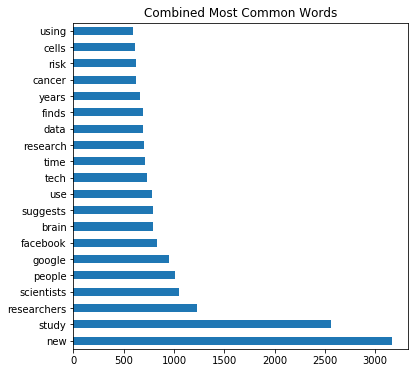

In [27]:
plt.figure(figsize=(6,6))
plt.title('Combined Most Common Words')
base_common.plot.barh();

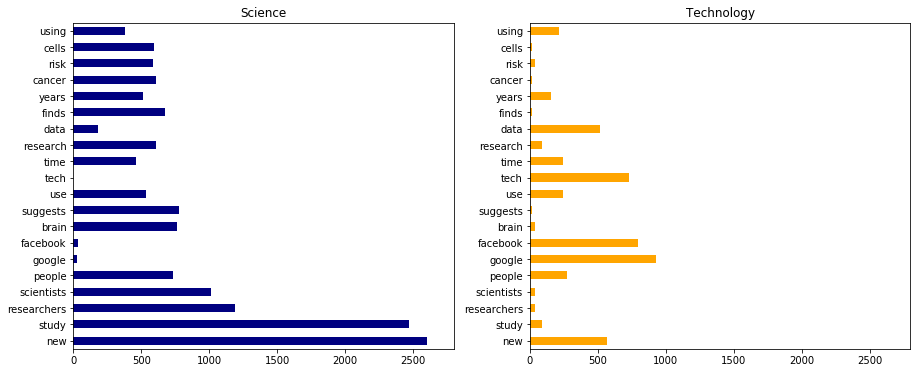

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
sci[base_common.index].sum().plot.barh(ax=ax1, title='Science', color='navy')
ax1.set_xlim(0,2800)
ax2.set_xlim(0,2800)
tech[base_common.index].sum().plot.barh(ax=ax2, title='Technology', color='orange');

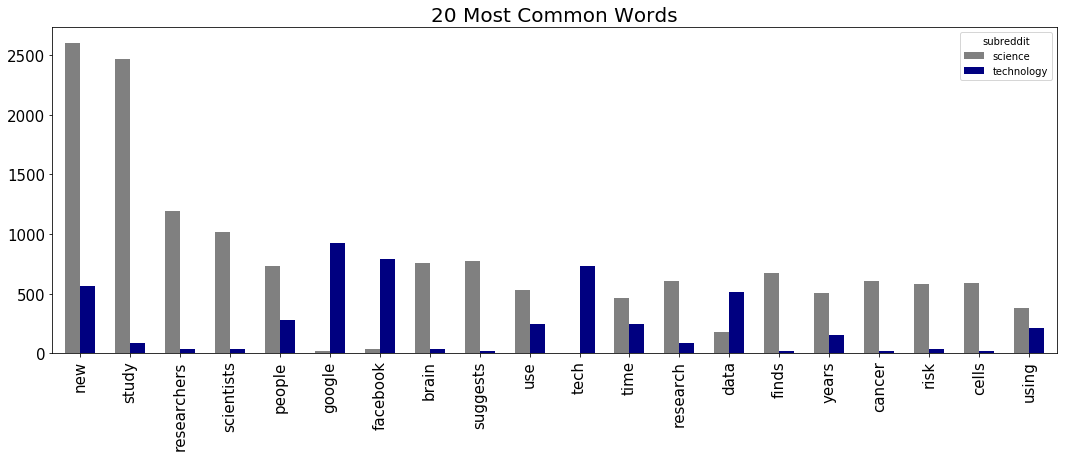

In [23]:
fig, ax = plt.subplots(figsize=(18,6))


groups = features.groupby(scitech['subreddit']).sum()[base_common.index].T.head(20)
plt.title('20 Most Common Words', fontsize=20)

groups.plot.bar(
                ax=ax,
                width=.6, 
                color=['gray','navy','orange'],
                fontsize=15,
                );

# Word Clouds!!!

### Entire dataset

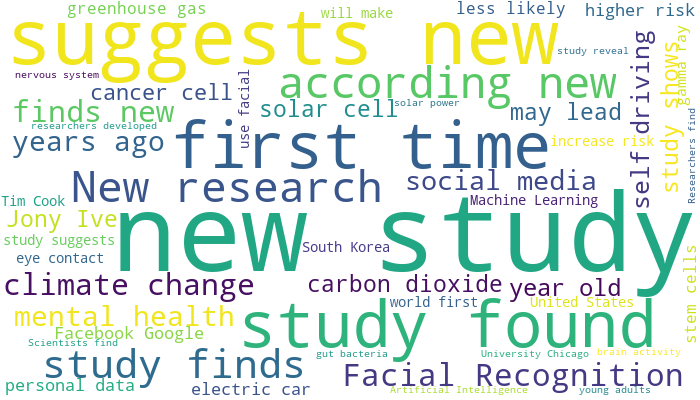

In [24]:
make_cloud(X)

### Science dataset

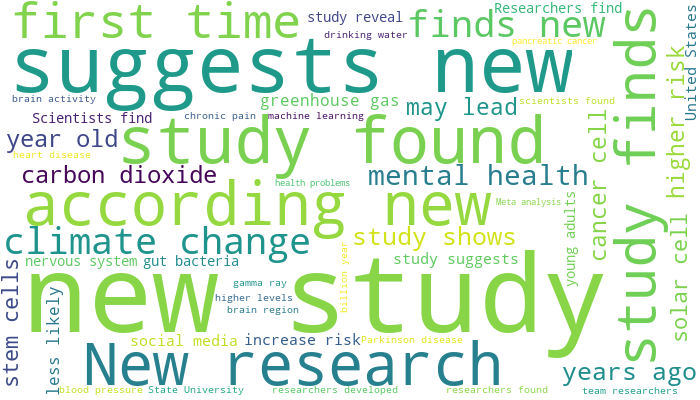

In [25]:
make_cloud(X=scitech[scitech['subreddit'] == 'science']['title'])

### Technology dataset

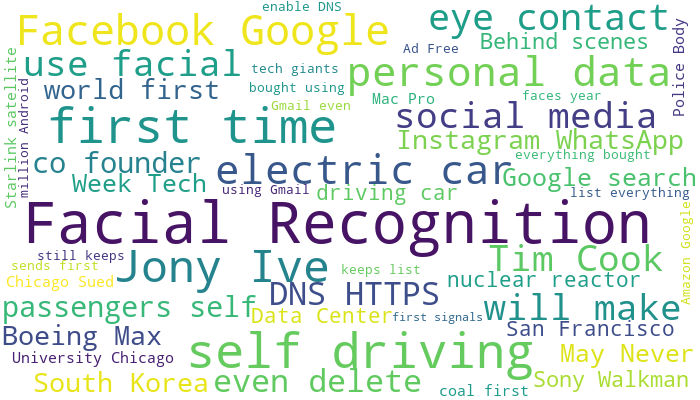

In [26]:
make_cloud(X=scitech[scitech['subreddit'] == 'technology']['title'])

## Baseline

In [27]:
scitech2['subreddit'].value_counts(normalize=True)

1    0.500603
0    0.499397
Name: subreddit, dtype: float64

## Train/Test Split

In [28]:


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

---

# Logistic Regression Classifier

## Pipeline and GridSearchCV

In [29]:
lr_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

pipe_params = { 'tfidf__strip_accents': [None],
                'tfidf__stop_words': ['english'],
                'tfidf__ngram_range': [(1, 1)],                   
                'tfidf__max_features': [5000],
                'lr__penalty': ['l1'],
                'lr__C': [1]
                }

In [30]:
lr_grid = GridSearchCV(lr_pipe, param_grid=pipe_params, cv=5, verbose=1, n_jobs=-1)

lr_grid.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished


## Scoring

In [31]:
print(f'')
print(lr_grid.best_score_)

0.9985250737463127


In [32]:
lr_grid.score(X_train, y_train)

0.9993966210780371

In [33]:
lr_grid.score(X_test, y_test)

0.999597747385358

## Confusion Matrix

In [34]:
lr_predictions = lr_grid.predict(X_test)

In [35]:
lr_cm = confusion_matrix(y_test, lr_predictions)

In [36]:
lr_confusion_df = pd.DataFrame(lr_cm, columns=['Pred False', 'Pred True'], index=['Actual False', 'Actual True'])

**True is Science**

In [37]:
lr_confusion_df

,Pred False,Pred True
Actual False,2597,0
Actual True,2,2373


In [38]:
tn, fp, fn, tp = lr_cm.ravel()

### Specificity

In [39]:
lr_spec = tn / (tn + fp)
lr_spec

1.0

### Sensitivity/Recall

In [40]:
lr_sens = tp / (tp +fn)
lr_sens

0.9991578947368421

### ROC AUC Score

In [41]:
lr_auc = roc_auc_score(y_test, lr_predictions)
lr_auc

0.9995789473684211

### ROC AUC Curve

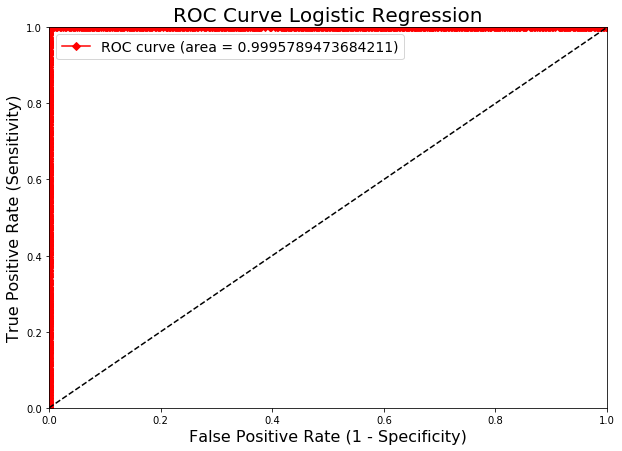

In [42]:
lr_probs = lr_grid.predict_proba(X_test)[:,1]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_probs)

plt.figure(figsize=(10, 7))
plt.plot(lr_fpr, lr_tpr, label=f'ROC curve (area = {lr_auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve Logistic Regression', size=20)
plt.legend(fontsize=14);

# Histograms!

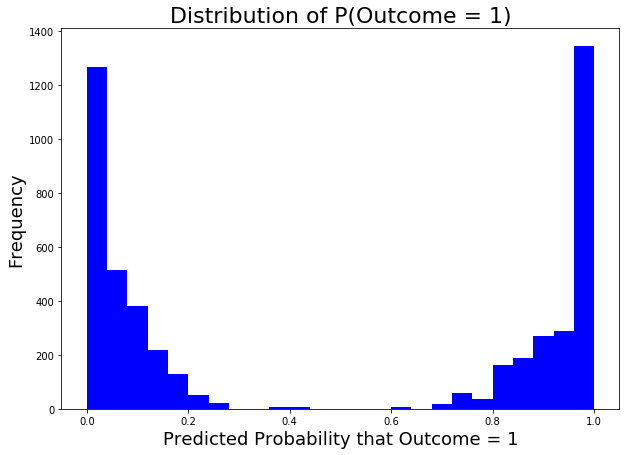

In [43]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(lr_probs, bins=25, color='b')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

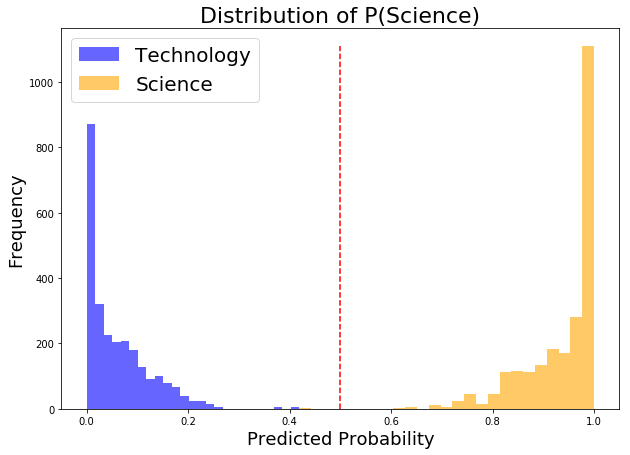

In [44]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(lr_probs[y_test == 0],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(lr_probs[y_test == 1],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)

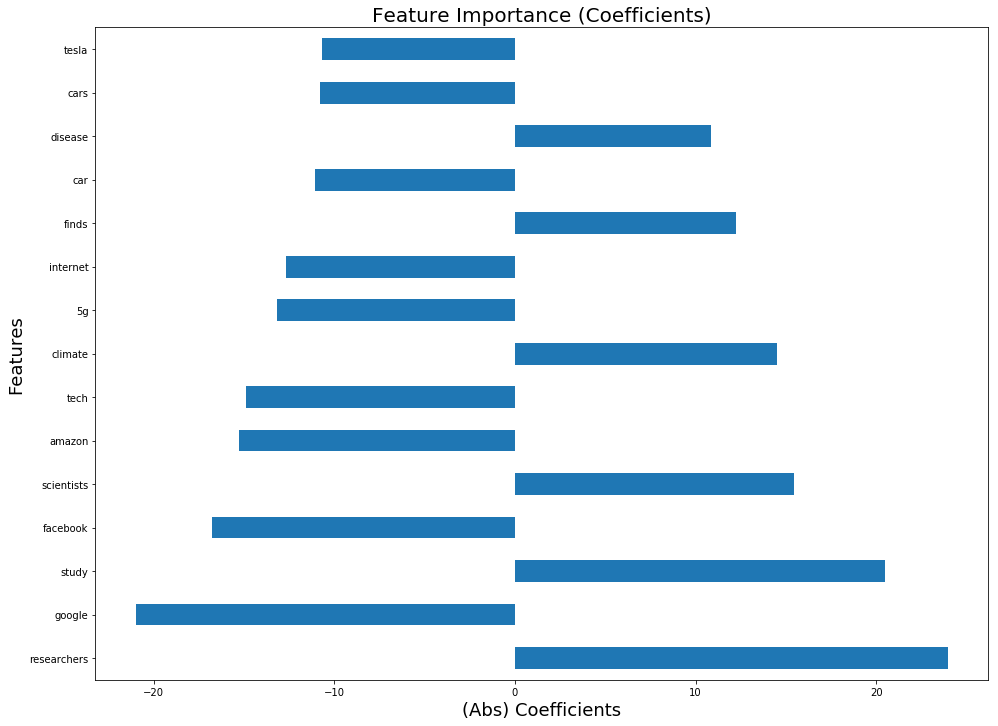

In [45]:
lr_feats = lr_grid.best_estimator_.named_steps['tfidf'].get_feature_names()

lr_catcher = lr_grid.best_estimator_.named_steps['lr']


plt.figure(figsize=(16, 12))
plt.title('Feature Importance (Coefficients)', fontsize=20)
plt.ylabel('Features', fontsize=18)
plt.xlabel('(Abs) Coefficients', fontsize=18)

coef_df = pd.DataFrame(lr_catcher.coef_, columns=lr_feats).T
coef_df['abs_coef'] = coef_df[0].abs()
coef_df.sort_values('abs_coef', ascending=False)[0].head(15).plot(kind='barh');

# coef_kill = coef_df.sort_values('abs_coef', ascending=False)[0].head(500).index

# coef_kill


# my_stops.extend(coef_kill)

# Multinomial Naive Bayes Classifier

## Pipeline and GridSearchCV

In [46]:
mnb_pipe = Pipeline([('count_vec', CountVectorizer()), ('mnb', MultinomialNB())])

pipe_params = {'count_vec__max_features': [5000],
                'count_vec__max_df': [.2],
                'count_vec__ngram_range': [(1,2)],
                'count_vec__stop_words': ['english'],
                'count_vec__min_df': [5],
                'mnb__fit_prior': [False],
                'mnb__alpha': [0]
                }

In [47]:
mnb_grid = GridSearchCV(mnb_pipe, param_grid=pipe_params, cv=5, verbose=0, n_jobs=-1)

mnb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('count_vec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                       

## Scoring

In [48]:
print(mnb_grid.best_score_)

0.9835076427996782


In [49]:
mnb_grid.score(X_train, y_train)

0.9872620005363368

In [50]:
mnb_grid.score(X_test, y_test)

0.9851166532582462

## Confusion Matrix

In [51]:
mnb_predictions = mnb_grid.predict(X_test)

In [52]:
mnb_cm = confusion_matrix(y_test, mnb_predictions)

In [53]:
mnb_confusion_df = pd.DataFrame(mnb_cm, columns=['Pred False', 'Pred True'], index=['Actual False', 'Actual True'])

**True is Science**

In [54]:
mnb_confusion_df

,Pred False,Pred True
Actual False,2530,67
Actual True,7,2368


In [55]:
tn, fp, fn, tp = mnb_cm.ravel()

### Specificity

In [56]:
mnb_spec = tn / (tn + fp)
mnb_spec

0.974201001155179

### Sensitivity/Recall

In [57]:
mnb_sens = tp / (tp +fn)
mnb_sens

0.9970526315789474

### ROC AUC Score

In [58]:
mnb_auc = roc_auc_score(y_test, mnb_predictions)
mnb_auc

0.9856268163670633

### ROC AUC Curve

In [59]:
mnb_probs = mnb_grid.predict_proba(X_test)

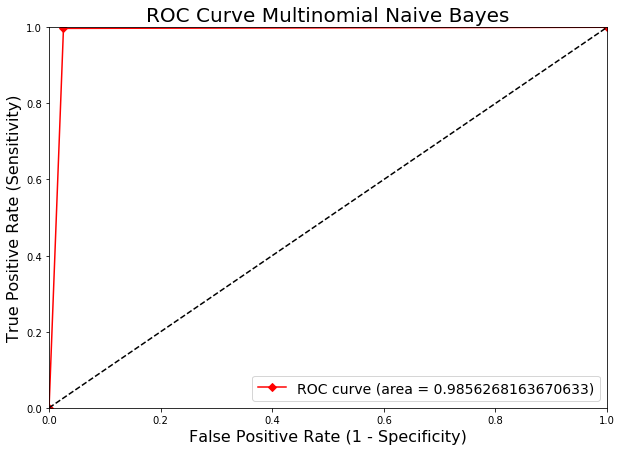

In [60]:
mnb_fpr, mnb_tpr, mnb_thresholds = roc_curve(y_test, mnb_predictions)


# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(mnb_fpr, mnb_tpr, label=f'ROC curve (area = {mnb_auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve Multinomial Naive Bayes', size=20)
plt.legend(fontsize=14);



In [61]:
mnb_feats = mnb_grid.best_estimator_.named_steps['count_vec'].get_feature_names()

mnb_catcher = mnb_grid.best_estimator_.named_steps['mnb']

sparse_matrix = mnb_grid.best_estimator_.named_steps['count_vec'].fit_transform(X_test)

dense_matrix = sparse_matrix.todense()

feature_df = pd.DataFrame(dense_matrix, columns=mnb_feats)

# top_feats = feature_df.sum().sort_values(ascending=False)[:10,].index

# top_feats
# my_stops = ENGLISH_STOP_WORDS
# my_stops.extend(top_feats)



# Histograms!

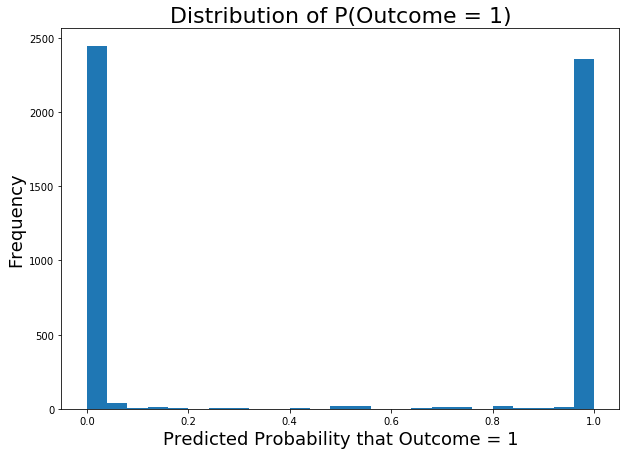

In [62]:
# Create figure.
plt.figure(figsize = (10,7))

# fix the probs
mnb_probs2 = [i[1] for i in mnb_probs]

# Create histogram of observations.
plt.hist(mnb_probs2, bins=25)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

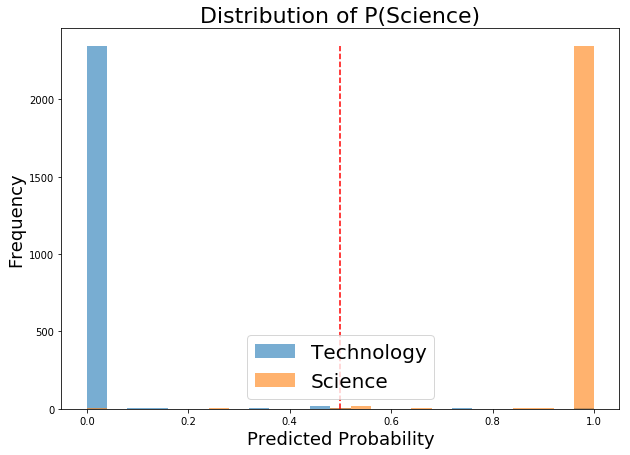

In [63]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
mnb_probs4 = [i[0] for i in mnb_probs[y_test == 1]]
hst2 = plt.hist((mnb_probs4),
         bins=25,
         alpha = 0.6,
         label='Technology')

# Get half of the probs for other half
mnb_probs3 = [i[1] for i in mnb_probs[y_test == 1]]
hst3 = plt.hist((mnb_probs3),
         bins=25,
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst2[0].max(), hst3[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20, loc='best');

# Thanks to Matt Brems for the colorful graphs! :)